In [2]:
!pip install wfdb

In [25]:
### libraries

import pandas as pd
import numpy as np
import wfdb
import urllib.request
import matplotlib.pyplot as plt

# !pip install keras
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding, MaxPooling1D
from keras.layers import Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import time
from keras import metrics

print('import done')
### List of records
records = wfdb.io.get_record_list(db_dir = 'mitdb', records='all')
print(records )

import done
['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']


In [5]:
### Dataframe of voltages

list_volt_0 = []
for i in records:
  image = wfdb.rdrecord(i, pn_dir='mitdb', sampto = 648000, channels=[0])
  signals_array, fields_dictionary = wfdb.rdsamp(i, pn_dir='mitdb', sampto = 648000, channels=[0])
  voltages = pd.DataFrame(signals_array)
  list_volt_0.append(voltages)

df_volt_0 = pd.concat(list_volt_0, axis=1) 
df_volt_0.columns = records 
df_volt_0.index.name = 'Time'
df_volt_0 = df_volt_0.reset_index()
df_volt_0 = pd.melt(df_volt_0,
                       id_vars = 'Time',
                       var_name="Patient",
                       value_name="Voltage_L2")
df_volt_0

,Time,Patient,Voltage_L2
0,0,100,-0.145
1,1,100,-0.145
2,2,100,-0.145
3,3,100,-0.145
4,4,100,-0.145
...,...,...,...
31103995,647995,234,-0.245
31103996,647996,234,-0.245
31103997,647997,234,-0.235
31103998,647998,234,-0.240


In [6]:
# adjusting df for merging at a later time
df_volt = df_volt_0
df_volt['Window'] = [i for i in range(8640) for _ in range(3600)] 
#8640 = 31,104,444(48 patients * sampleto number) / 3600

time_adj = pd.concat([pd.Series(range(3600))] * 8640, axis=0)
time_adj = pd.DataFrame(time_adj.reset_index(drop=True))
time_adj.columns = ['Time_Adj']
df_list = [df_volt, time_adj]
df_volt = pd.concat(df_list, axis=1)
df_volt



,Time,Patient,Voltage_L2,Window,Time_Adj
0,0,100,-0.145,0,0
1,1,100,-0.145,0,1
2,2,100,-0.145,0,2
3,3,100,-0.145,0,3
4,4,100,-0.145,0,4
...,...,...,...,...,...
31103995,647995,234,-0.245,8639,3595
31103996,647996,234,-0.245,8639,3596
31103997,647997,234,-0.235,8639,3597
31103998,647998,234,-0.240,8639,3598


In [7]:
### Annotations dataframe

list_ann = []
for i in records:
    ann = wfdb.rdann(i, 'atr', sampto = 648000, pn_dir='mitdb')
    labels_ann = ann.symbol
    annotated_time = ann.sample
    ann_df = pd.DataFrame({'Patient': i, 'Time':annotated_time, 'Annotation': labels_ann})
    list_ann.append(ann_df)
    
anns = pd.concat(list_ann, axis=0)
anns = anns.set_index(['Patient', 'Time'])['Annotation'].reset_index()
anns = anns.replace({'+':'N'})

anns['Results'] = np.where(anns['Annotation'] == 'x', 1, 0) #U is noisey data, labelled as 1
#anns

In [8]:
total = anns['Results'].sum()
print(total)

192


In [9]:
### Combining Windows Column from Voltage DF to Annotations DF

anns = df_volt.merge(anns, how='left', on = ['Patient', 'Time'])
anns = anns.pivot_table(values='Results', index='Window', aggfunc=np.sum)
anns.Results = np.where(anns['Results'] == 0, 0, 1)
#anns

In [10]:
### Merge Voltages and Annotations
mitdb_df = df_volt.merge(anns, how='left', on = ['Window'])
mitdb_df

,Time,Patient,Voltage_L2,Window,Time_Adj,Results
0,0,100,-0.145,0,0,0
1,1,100,-0.145,0,1,0
2,2,100,-0.145,0,2,0
3,3,100,-0.145,0,3,0
4,4,100,-0.145,0,4,0
...,...,...,...,...,...,...
31103995,647995,234,-0.245,8639,3595,0
31103996,647996,234,-0.245,8639,3596,0
31103997,647997,234,-0.235,8639,3597,0
31103998,647998,234,-0.240,8639,3598,0


In [11]:
#### Dataframe by ECG Window
# Ignored Patient
# Results in 0 (normal ECG window) or 1 (abnormal ECG window)

df_by_window = mitdb_df.set_index(['Window','Patient','Results','Time_Adj'])['Voltage_L2'].unstack().reset_index()

#df_by_window
# df_by_window.to_csv('ECG_window_df.csv')


In [13]:

df_by_window.to_csv('ECG_window_df.csv')

In [26]:
df_by_window

Time_Adj,Window,Patient,Results,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,3560,3561,3562,3563,3564,3565,3566,3567,3568,3569,3570,3571,3572,3573,3574,3575,3576,3577,3578,3579,3580,3581,3582,3583,3584,3585,3586,3587,3588,3589,3590,3591,3592,3593,3594,3595,3596,3597,3598,3599
0,0,100,0,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.120,-0.135,-0.145,-0.150,-0.160,-0.155,-0.160,-0.175,-0.180,-0.185,-0.170,-0.155,-0.175,-0.180,-0.190,-0.180,-0.155,-0.135,-0.155,-0.190,-0.205,-0.235,-0.225,-0.245,-0.250,-0.260,-0.275,-0.275,-0.275,...,0.835,0.720,0.410,0.030,-0.255,-0.415,-0.470,-0.465,-0.435,-0.395,-0.375,-0.370,-0.375,-0.375,-0.390,-0.400,-0.380,-0.385,-0.385,-0.385,-0.385,-0.370,-0.370,-0.360,-0.380,-0.380,-0.385,-0.370,-0.370,-0.365,-0.375,-0.385,-0.390,-0.390,-0.385,-0.385,-0.395,-0.390,-0.400,-0.405
1,1,100,0,-0.390,-0.395,-0.390,-0.405,-0.405,-0.400,-0.375,-0.380,-0.390,-0.395,-0.395,-0.390,-0.390,-0.385,-0.405,-0.400,-0.405,-0.395,-0.390,-0.395,-0.390,-0.400,-0.405,-0.405,-0.390,-0.390,-0.395,-0.400,-0.400,-0.395,-0.380,-0.370,-0.380,-0.385,-0.395,-0.390,-0.380,...,-0.385,-0.400,-0.390,-0.385,-0.385,-0.375,-0.380,-0.395,-0.405,-0.385,-0.380,-0.375,-0.380,-0.380,-0.390,-0.390,-0.380,-0.355,-0.355,-0.370,-0.385,-0.375,-0.385,-0.375,-0.390,-0.390,-0.400,-0.400,-0.385,-0.390,-0.390,-0.405,-0.415,-0.405,-0.405,-0.405,-0.410,-0.425,-0.430,-0.420
2,2,100,0,-0.405,-0.410,-0.410,-0.410,-0.410,-0.400,-0.385,-0.370,-0.375,-0.360,-0.365,-0.355,-0.335,-0.315,-0.315,-0.310,-0.315,-0.295,-0.290,-0.270,-0.285,-0.290,-0.290,-0.280,-0.275,-0.255,-0.270,-0.275,-0.275,-0.280,-0.255,-0.245,-0.260,-0.255,-0.265,-0.260,-0.260,...,-0.355,-0.360,-0.370,-0.370,-0.370,-0.360,-0.365,-0.365,-0.385,-0.385,-0.385,-0.375,-0.380,-0.390,-0.400,-0.400,-0.385,-0.385,-0.385,-0.390,-0.400,-0.405,-0.390,-0.380,-0.380,-0.390,-0.405,-0.395,-0.390,-0.385,-0.380,-0.380,-0.390,-0.375,-0.365,-0.365,-0.375,-0.375,-0.385,-0.385
3,3,100,0,-0.385,-0.365,-0.375,-0.380,-0.390,-0.385,-0.375,-0.360,-0.370,-0.380,-0.390,-0.390,-0.375,-0.365,-0.375,-0.360,-0.370,-0.355,-0.320,-0.310,-0.300,-0.300,-0.310,-0.310,-0.285,-0.270,-0.255,-0.275,-0.275,-0.270,-0.275,-0.270,-0.280,-0.295,-0.310,-0.305,-0.295,...,-0.225,-0.240,-0.250,-0.250,-0.250,-0.245,-0.245,-0.250,-0.245,-0.255,-0.250,-0.245,-0.265,-0.265,-0.275,-0.275,-0.245,-0.210,-0.205,-0.235,-0.275,-0.300,-0.290,-0.300,-0.330,-0.345,-0.350,-0.365,-0.355,-0.340,-0.350,-0.360,-0.375,-0.370,-0.370,-0.360,-0.365,-0.375,-0.380,-0.385
4,4,100,0,-0.360,-0.360,-0.360,-0.360,-0.380,-0.390,-0.395,-0.375,-0.405,-0.450,-0.490,-0.520,-0.545,-0.570,-0.600,-0.565,-0.480,-0.335,-0.170,0.040,0.315,0.570,0.730,0.770,0.655,0.380,0.000,-0.310,-0.485,-0.520,-0.475,-0.420,-0.410,-0.425,-0.425,-0.430,-0.430,...,-0.440,-0.430,-0.425,-0.430,-0.410,-0.415,-0.415,-0.420,-0.445,-0.455,-0.435,-0.425,-0.420,-0.430,-0.435,-0.435,-0.435,-0.425,-0.430,-0.430,-0.445,-0.450,-0.445,-0.430,-0.435,-0.430,-0.435,-0.430,-0.425,-0.420,-0.415,-0.415,-0.440,-0.445,-0.435,-0.425,-0.430,-0.440,-0.465,-0.460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,8635,234,0,0.920,1.210,1.465,1.635,1.660,1.565,1.345,1.045,0.710,0.380,0.075,-0.125,-0.250,-0.290,-0.300,-0.275,-0.255,-0.230,-0.225,-0.225,-0.245,-0.285,-0.325,-0.350,-0.355,-0.350,-0.335,-0.325,-0.320,-0.325,-0.340,-0.335,-0.315,-0.325,-0.345,-0.360,-0.385,...,-0.055,-0.070,-0.075,-0.085,-0.090,-0.075,-0.070,-0.060,-0.065,-0.060,-0.055,-0.050,-0.040,-0.035,-0.050,-0.055,-0.060,-0.060,-0.050,-0.040,-0.035,-0.035,-0.015,-0.030,-0.025,-0.015,-0.035,-0.040,-0.060,-0.055,-0.025,-0.005,0.000,0.005,0.015,0.010,0.005,0.010,0.000,-0.015
8636,8636,234,0,-0.030,-0.030,-0.030,-0.0

Now we use them

In [34]:
#---Dataset: Previously sectioned ECG recordings into 2-second windows---

df = pd.read_csv('/content/ECG_window_df.csv')

print('Dataset before the split:')
print(df.shape)

Dataset before the split:
(8640, 3604)


In [35]:
#---Train and Test split manually (test with patient 233 and 234 ECG windows)---

train = df.iloc[0:36900] 
test = df.iloc[-6300:]

X_train = train[train.columns[3:723]] #voltages, train
X_test = test[test.columns[3:723]]    #voltages, test
Y_train = train.Results               #results, train
Y_test = test.Results                 #results, test


print('Train Shape - voltages, results:')
print(X_train.shape, Y_train.shape)
print('Test Shape - voltages, results:')
print(X_test.shape, Y_test.shape)

Train Shape - voltages, results:
(8640, 720) (8640,)
Test Shape - voltages, results:
(6300, 720) (6300,)


In [36]:
#---Model---

batch = 16
epochs = 10
shape = np.size(X_train,1)


model = Sequential()
model.add(Dense(100, activation='relu', input_shape = (shape,1)))
model.add(Dropout(0.1))
model.add(Conv1D(100, 10, activation='relu'))
model.add(Conv1D(100, 10, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(160, 10, activation='relu'))
model.add(Conv1D(160, 10, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid')) 
model.summary()
model.compile(loss='binary_crossentropy',
        optimizer='rmsprop',
        metrics=['accuracy'])


X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)


network_history = model.fit(X_train,Y_train, batch_size = batch, epochs = epochs 
                            , validation_split=0.2)
score = model.evaluate(X_test, Y_test, batch_size = batch)
score

y_pred = model.predict(X_test, batch_size = batch)
threshold = 0.5
y_pred1 = y_pred[:,0] < threshold
cm = confusion_matrix(Y_test, y_pred1)
cm



Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 720, 100)          200       
_________________________________________________________________
dropout_17 (Dropout)         (None, 720, 100)          0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 711, 100)          100100    
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 702, 100)          100100    
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 234, 100)          0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 225, 160)          160160    
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 216, 160)         

array([[   0, 6231],
       [   0,   69]])

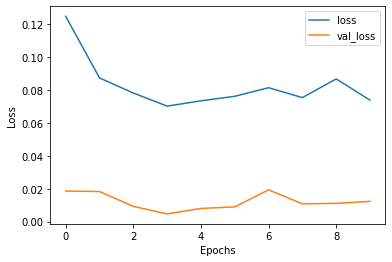

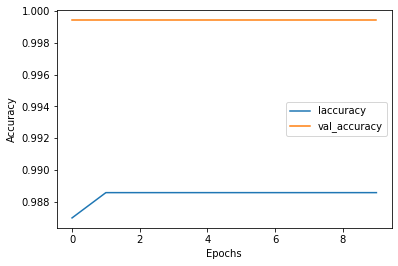

In [37]:
# Plot themresults 
def plot_history(network_history):
  history = network_history.history
  losses = history['loss']
  val_losses = history['val_loss']
  accuracies = history['accuracy']
  val_accuracies = history['val_accuracy']
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.plot(losses)
  plt.plot(val_losses)
  plt.legend(['loss' , 'val_loss'])


  plt.figure()
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.plot(accuracies)
  plt.plot(val_accuracies)
  plt.legend(['laccuracy' , 'val_accuracy'])



plot_history(network_history)